# Скважины

<b>Цель работы:</b> построить модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой Bootstrap.

<b>Условия задачи:</b>

   - Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
   - При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
   - Бюджет на разработку скважин в регионе — 10 млрд рублей.
   - При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
   - После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.


<b> Характеристика данных: </b>
- id — уникальный идентификатор скважины;
-  f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
-  product — объём запасов в скважине (тыс. баррелей).

In [1]:
#импортируем основные библиотеки
import pandas as pd
import numpy as np
import math

#визуализация
import seaborn as sns
import matplotlib.pyplot as plt

from numpy.random import RandomState

#модели & метрики & инструменты
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
#прочитаем файлы
try:
    data_0 = pd.read_csv('desktop/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('desktop/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('desktop/datasets/geo_data_2.csv')
except:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')
    

In [3]:
#посмотрим на датасет по первому региону
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
#посмотрим на датасет по второму региону
data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
#посмотрим на датасет по третьему региону
data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [6]:
#посмотрим на основную информацию по датасетам
print(data_0.info())
print('')
print(data_1.info())
print('')
print(data_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column

In [7]:
#посмотрим на статистику, чтобы предварительно оценить распределение (первый регион)
data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [8]:
#посмотрим на статистику, чтобы предварительно оценить распределение (второй регион)
data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [9]:
#посмотрим на статистику, чтобы предварительно оценить распределение (третий регион)
data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [10]:
#посмотрим распределение на boxplot
def boxplot_fact(data):
   
    sns.set_style('darkgrid')  
    plt.title('Распределение данных в датесете по столбцам')
    data.boxplot(column='f0',figsize=(6,3))
    plt.show()
    data.boxplot(column='f1',figsize=(6,3))
    plt.show()
    data.boxplot(column='f2',figsize=(6,3))
    plt.show()
    data.boxplot(column='product',figsize=(6,3))
    plt.show()
    

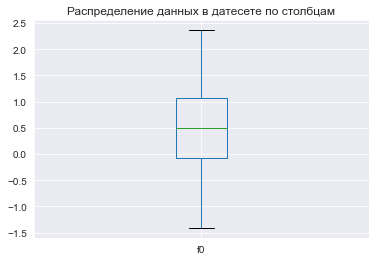

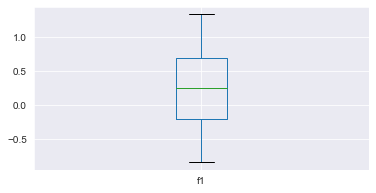

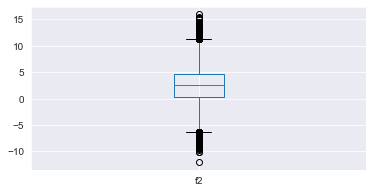

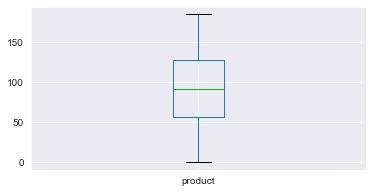

In [11]:
#распределение на boxplot, первый регион
boxplot_fact(data_0)

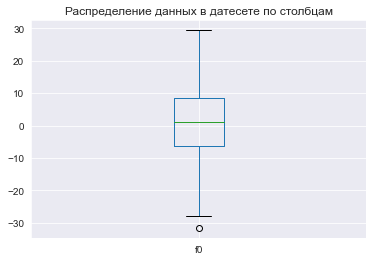

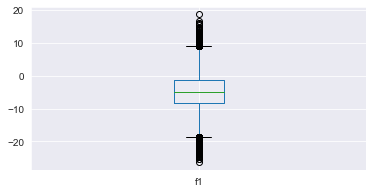

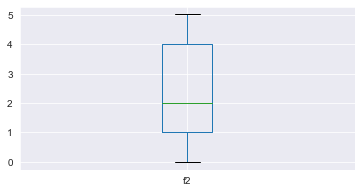

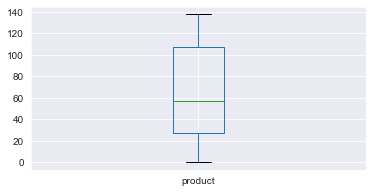

In [12]:
#распределение на boxplot, второй регион
boxplot_fact(data_1)

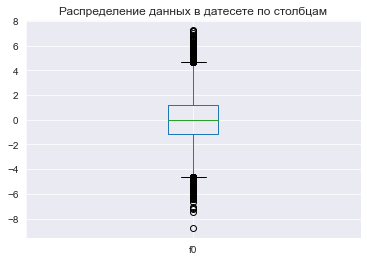

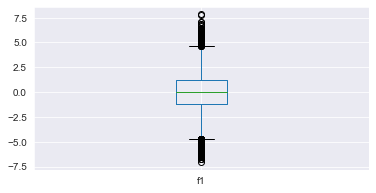

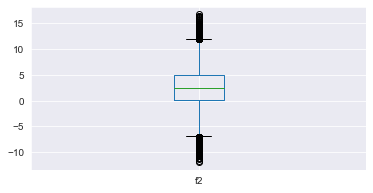

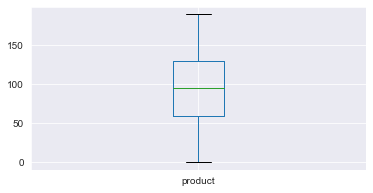

In [13]:
#распределение на boxplot, третий регион
boxplot_fact(data_2)

In [14]:
#функция, позволяющая просмотреть основную информацию о датасете и признаках 
def distribution(data):
    print("Количество пропусков: {}". format(data.isna().sum().sum()))
    print("Дубликаты: {}".format(data.duplicated().sum()))
    print()
    print("Распределение признаков:")
    fig, axs = plt.subplots(ncols=4,figsize=(10,5))
    data[['f0','f1','f2','product']].hist(bins=15,ax=axs[0],color='g',alpha=0.5)
    plt.show()

Количество пропусков: 0
Дубликаты: 0

Распределение признаков:


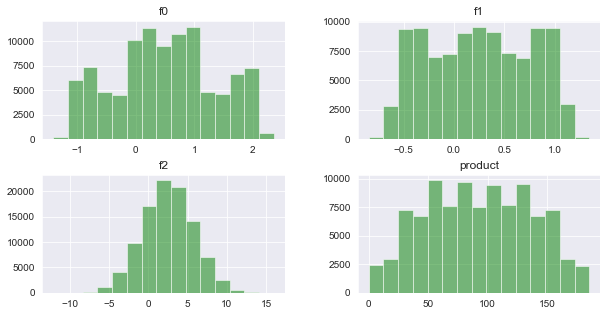

In [15]:
distribution(data_0)

Количество пропусков: 0
Дубликаты: 0

Распределение признаков:


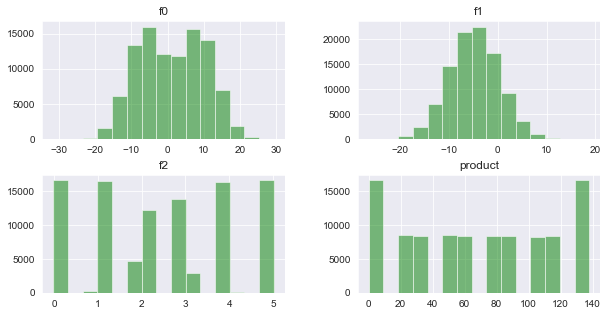

In [16]:
distribution(data_1)

Количество пропусков: 0
Дубликаты: 0

Распределение признаков:


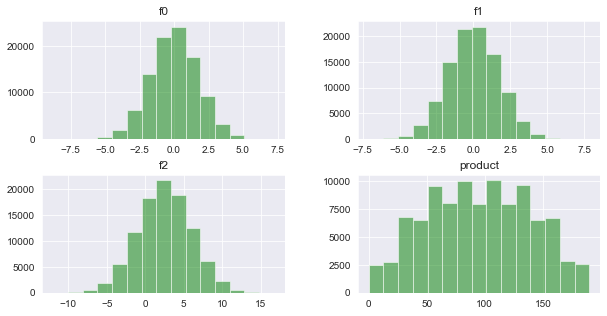

In [17]:
distribution(data_2)

In [18]:
#посмотрим на наличие нулевых значений
def null_counts(data):
    zeros_f0 = data[data['f0'] == 0]['f0'].count()
    percent_f0 = round((zeros_f0/data.shape[0])*100,3)
    print('Количество нулевых значений по f0 -', zeros_f0)
    print('Процент нулевых значений f0-', percent_f0,'%')
    
    print()
    zeros_f1 = data[data['f1'] == 0]['f1'].count()
    percent_f1 = round((zeros_f1/data.shape[0])*100,3)
    print('Количество нулевых значений по f1 -', zeros_f1)
    print('Процент нулевых значений f1 -', percent_f1,'%')
    
    print()
    zeros_f2 = data[data['f2'] == 0]['f2'].count()
    percent_f2 = round((zeros_f2/data.shape[0])*100,3)
    print('Количество нулевых значений по f2 -', zeros_f2)
    print('Процент нулевых значений f2 -', percent_f2,'%')
    print()

    zeros_product = data[data['product'] == 0]['product'].count()
    percent_product = round((zeros_product/data.shape[0])*100,3)
    print('Количество нулевых значений по Product -', zeros_product)
    print('Процент нулевых значений Product -', percent_product,'%')
    print()

In [19]:
#количество нулевых значений в первом датасете
null_counts(data_0)

Количество нулевых значений по f0 - 0
Процент нулевых значений f0- 0.0 %

Количество нулевых значений по f1 - 0
Процент нулевых значений f1 - 0.0 %

Количество нулевых значений по f2 - 0
Процент нулевых значений f2 - 0.0 %

Количество нулевых значений по Product - 1
Процент нулевых значений Product - 0.001 %



In [20]:
#количество нулевых значений в первом датасете
null_counts(data_1)

Количество нулевых значений по f0 - 0
Процент нулевых значений f0- 0.0 %

Количество нулевых значений по f1 - 0
Процент нулевых значений f1 - 0.0 %

Количество нулевых значений по f2 - 0
Процент нулевых значений f2 - 0.0 %

Количество нулевых значений по Product - 8235
Процент нулевых значений Product - 8.235 %



In [21]:
#количество нулевых значений в первом датасете
null_counts(data_2)

Количество нулевых значений по f0 - 0
Процент нулевых значений f0- 0.0 %

Количество нулевых значений по f1 - 0
Процент нулевых значений f1 - 0.0 %

Количество нулевых значений по f2 - 0
Процент нулевых значений f2 - 0.0 %

Количество нулевых значений по Product - 1
Процент нулевых значений Product - 0.001 %



In [22]:
#удалим лишние столбцы
data_0 = data_0.drop(['id'], axis=1)
data_1 = data_1.drop(['id'], axis=1)
data_2 = data_2.drop(['id'], axis=1)

<b>Вывод по разделу:</b>
- пропусков и дубликатов в данных не обнаруждено,
- во 1 и 3 региона распределение данных близко к нормальному,
- данные во втором регионе распределены странно,
- во втором регионе в столбце Product есть нулевые значения, около 8%,
- удален столбце id, который не несет смысловой нагрузки для машинного обучения.

## Обучение и проверка модели для каждого региона

In [23]:
#обучающая функция и считающая метрики

def train_model(data):
    # выделим признаки
    features = data.drop('product', axis=1) 
    target = data['product']
    
    # разобьём данные на тестовую и валидационную выборки в соотношении 75:25
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    
    # обучим модель
    parameters = {'fit_intercept':[True,False], 'copy_X':[True, False], 'normalize':[True,False]}
    model = GridSearchCV(estimator=LinearRegression(), param_grid=parameters, cv=5)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
        
    # посчитаем метрики
    data_metrics = {}
    
    # средний запас предсказанного сырья 
    data_metrics['predict_valid_mean'] = predicted_valid.mean()
    
    #метрика RMSE
    data_metrics['RMSE'] =  mean_squared_error(target_valid, predicted_valid) ** 0.5
    
    #лучшие параметры
    data_metrics['best_model_params'] = model.best_params_
    
    df = {'real_product' : target_valid,
            'predicted_product' : predicted_valid}
    df_df = pd.DataFrame(df, columns = ['real_product', 'predicted_product'])

    return data_metrics, df_df

In [24]:
#соберем метрики по каждому датасету и сохраненные предсказания 
data_metrics_0,real_pred_0=train_model(data_0)
data_metrics_1,real_pred_1=train_model(data_1)
data_metrics_2,real_pred_2=train_model(data_2)

In [25]:
#посмотрим датасет с предсказаниями и реальными значениями по первому региону
real_pred_0.head()

,real_product,predicted_product
71751,10.038645,95.894952
80493,114.551489,77.572583
2655,132.603635,77.892640
53233,169.072125,90.175134
91141,122.325180,70.510088


In [26]:
#посмотрим датасет с предсказаниями и реальными значениями по второму региону
real_pred_1.head()

,real_product,predicted_product
71751,80.859783,82.663314
80493,53.906522,54.431786
2655,30.132364,29.748760
53233,53.906522,53.552133
91141,0.000000,1.243856


In [27]:
#посмотрим датасет с предсказаниями и реальными значениями по третьему региону
real_pred_2.head()

,real_product,predicted_product
71751,61.212375,93.599633
80493,41.850118,75.105159
2655,57.776581,90.066809
53233,100.053761,105.162375
91141,109.897122,115.303310


In [28]:
#напечатаем запас средний запас сырья и метрику rmse + лучшие параметры модели

print('Средняя предсказанного сырья первого региона: {}'. format(data_metrics_0['predict_valid_mean']))
print('RMSE первого региона: {}'. format(data_metrics_0['RMSE']))

print()
print('Средняя предсказанного сырья второго региона: {}'. format(data_metrics_1['predict_valid_mean']))
print('RMSE первого региона: {}'. format(data_metrics_1['RMSE']))

print()
print('Средняя предсказанного сырья третьего региона: {}'. format(data_metrics_2['predict_valid_mean']))
print('RMSE первого региона: {}'. format(data_metrics_2['RMSE']))

print()

Средняя предсказанного сырья первого региона: 92.59256778438035
RMSE первого региона: 37.5794217150813

Средняя предсказанного сырья второго региона: 68.72854689544602
RMSE первого региона: 0.8930992867756167

Средняя предсказанного сырья третьего региона: 94.96504596800489
RMSE первого региона: 40.02970873393434



In [29]:
#лучшие параметры модели
data_metrics_0['best_model_params']

{'copy_X': True, 'fit_intercept': True, 'normalize': True}

<b>Вывод по разделу:</b> Лучшей по RMSE оказалась модель во втором регионе. Средняя предсказанного сырья больше у третьего региона. 

## Подготовка к расчёту прибыли

<b>3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.</b>

In [30]:
#бюджет на разработку
budget = 10_000_000 #10 млрд в тысячах рублей

#число исследуемых точек
investigated_points = 500

#число лучших точек
top_points = 200

#доход с 1 точки
price_per_barrel = 450

In [31]:
#стоимость разработки точки
cost_of_point = math.ceil(budget / top_points)
print('Стоимость разрабоки точки - {} тыс.руб.'.format(cost_of_point))

oil_per_point = math.ceil(cost_of_point  / price_per_barrel)
print('Средний объем нефти на точку - {} тыс. барелей'.format(oil_per_point))

oil_volume = math.ceil(budget / price_per_barrel)
print('Средний объем нефти на регион - {} тыс. барелей'.format(oil_volume))

Стоимость разрабоки точки - 50000 тыс.руб.
Средний объем нефти на точку - 112 тыс. барелей
Средний объем нефти на регион - 22223 тыс. барелей


<b> 3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.</b>

In [32]:
#По фактическим запасам
print('Средний запас фактичекой нефти на скважину в регионе 1', data_0['product'].mean())
print('Средний запас фактичекой нефти на скважину в регионе 2', data_1['product'].mean())
print('Средний запас фактичекой нефти на скважину в регионе 3', data_2['product'].mean())

Средний запас фактичекой нефти на скважину в регионе 1 92.49999999999974
Средний запас фактичекой нефти на скважину в регионе 2 68.82500000002561
Средний запас фактичекой нефти на скважину в регионе 3 95.00000000000041


<b>Вывод по разделу:</b> Средний объем нефти на точку 112 тыс.баррелей, такого запаса нет ни на одной из точек, согласно данным по средней, лучшая модель так же предсказала значение ниже.

## Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

<b> 4.1. Выберите скважины с максимальными значениями предсказаний.</b>

In [33]:
#выберем данные из таблиц по регионам: лучшие скважтины по сырью
top_prediction_0=real_pred_0.sort_values(by='predicted_product', ascending=False)[:200]
top_prediction_1=real_pred_1.sort_values(by='predicted_product', ascending=False)[:200]
top_prediction_2=real_pred_2.sort_values(by='predicted_product', ascending=False)[:200]

<b> 4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.</b>

In [34]:
#суммируем целевое значение объема сырья по регионам
sum_product_0 = math.floor(top_prediction_0['real_product'].sum())
print('Целевое значение объёма сырья первого региона: {} тыс.баррелей'.format(sum_product_0))
sum_product_1 = math.floor(top_prediction_1['real_product'].sum())
print('Целевое значение объёма сырья второго региона: {} тыс.баррелей'.format(sum_product_1))
sum_product_2 = math.floor(top_prediction_2['real_product'].sum())
print('Целевое значение объёма сырья третьего региона: {} тыс.баррелей'.format(sum_product_2))

Целевое значение объёма сырья первого региона: 29601 тыс.баррелей
Целевое значение объёма сырья второго региона: 27589 тыс.баррелей
Целевое значение объёма сырья третьего региона: 28245 тыс.баррелей


<b> 4.3. Рассчитайте прибыль для полученного объёма сырья.</b>

In [35]:
profit_data_0 = sum_product_0 * price_per_barrel  - budget
print('Прибыль для полученного объёма сырья первый регион: {} тыс.руб.'.format(profit_data_0 ))
profit_data_1 = sum_product_1 * price_per_barrel  - budget
print('Прибыль для полученного объёма сырья второй регион: {} тыс.руб.'.format(profit_data_1 ))
profit_data_2 = sum_product_2 * price_per_barrel - budget
print('Прибыль для полученного объёма сырья третий регион: {} тыс.руб.'.format(profit_data_2 ))

Прибыль для полученного объёма сырья первый регион: 3320450 тыс.руб.
Прибыль для полученного объёма сырья второй регион: 2415050 тыс.руб.
Прибыль для полученного объёма сырья третий регион: 2710250 тыс.руб.


<b>Вывод по разделу:</b> 
- Затраты на основение скважины - 50 млн.руб;
- По 200 лучшим точкам согласно фактической информации запасов нефти от 28245 тыс.баррелей до 29601 тыс.баррелей
- По фактическим данным прибыль на 200 лучших точках составит от 2,7 млрд.р. до 3,3 млрд.руб

## Риски и прибыль для каждого региона, Bootstrap

<b>  
    
5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
    
5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
    
5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

</b>

In [36]:
#функция для подсчет прибыли
def profit_counting(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return price_per_barrel * selected.sum() - budget

In [37]:
#бутстрап
state = np.random.RandomState(12345)

def bootstrap_data(target, probs):
    values=[]
    lost = 0
    for i in range(1000):
        target_sample = target.sample(replace=True, random_state=state, n=investigated_points)
        probs_sample = probs[target_sample.index]
        profit = profit_counting(target, probs_sample, top_points)
        if profit < 0:
            lost +=1
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = lost / 1000
    return average, lower, upper, risk

In [38]:
#получим среднюю прибыль/доверительный интервал и риск (в %)  по первому региону
average_0, lower_0, upper_0, risk_0 = bootstrap_data(real_pred_0['real_product'],real_pred_0['predicted_product'])
print('ПЕРВЫЙ РЕГИОН')
print('Средняя прибыль по региону = {:.0f} тыс.руб.'.format(average_0))
print('95% доверительный интервал от {:.0f} до {:.0f} тыс.руб.'.format(lower_0, upper_0))
print('Риск {:.2%}'.format(risk_0))

ПЕРВЫЙ РЕГИОН
Средняя прибыль по региону = 396165 тыс.руб.
95% доверительный интервал от -111216 до 909767 тыс.руб.
Риск 6.90%


In [39]:
#получим среднюю прибыль/доверительный интервал и риск (в %)  по второму региону
average_1, lower_1, upper_1, risk_1 = bootstrap_data(real_pred_1['real_product'],real_pred_1['predicted_product'])
print('ВТОРОЙ РЕГИОН')
print('Средняя прибыль по региону = {:.0f} тыс.руб.'.format(average_1))
print('95% доверительный интервал от {:.0f} до {:.0f} тыс.руб.'.format(lower_1, upper_1))
print('Риск {:.2%}'.format(risk_1))

ВТОРОЙ РЕГИОН
Средняя прибыль по региону = 461156 тыс.руб.
95% доверительный интервал от 78051 до 862952 тыс.руб.
Риск 0.70%


In [40]:
#получим среднюю прибыль/доверительный интервал и риск (в %) по третьему региону
average_2, lower_2, upper_2, risk_2 = bootstrap_data(real_pred_2['real_product'],real_pred_2['predicted_product'])
print('ТРЕТИЙ РЕГИОН')
print('Средняя прибыль по региону = {:.0f} тыс.руб.'.format(average_2))
print('95% доверительный интервал от {:.0f} до {:.0f} тыс.руб.'.format(lower_2, upper_2))
print('Риск {:.2%}'.format(risk_2))

ТРЕТИЙ РЕГИОН
Средняя прибыль по региону = 392950 тыс.руб.
95% доверительный интервал от -112228 до 934563 тыс.руб.
Риск 6.50%


<b>Вывод по разделу:</b> 
- наименьший риск во втором регионе, но насколько известно из подготовки данных именно в этом регионе есть много нулевых значений в целевой переменной (8%) + распределение данных было странным,  возможно стоит выбрать из 1 или 3 региона;
- средняя прибыль по 1 и 3 региону сопоставима;
- если выбирать по рискам, то следует выбрать регион 3.

<b>ОБЩИЙ ВЫВОД:</b>

<b>1.</b> Была выполнена подготовки данных, в рамках которой:
 - проанализировано наличие пропусков и дубликатов (не обнаружено);
 - проанализировано распределение данных по всем столбцам датасета, представляющего каждый регион:
 
      -  1 и 3 регион все данные распределены близко к нормальному,
      - 2 регион распределен нестандартно,
 - в датасете во 2 регионе обранужены нулевые значения (8%);
 
<b>2.</b> Обучена модель, установлен средний запас предсказанного сырья и RMSE модели в каждом регионе.
- Средняя предсказанного сырья первого региона: 92.59256778438035
- <b>RMSE первого региона: 37.5794217150813</b>

- Средняя предсказанного сырья второго региона: 68.72854689544602
- RMSE первого региона: 0.8930992867756167

- <b>Средняя предсказанного сырья третьего региона: 94.96504596800489</b>
- RMSE первого региона: 40.02970873393434

Лидер по RMSE регион 1, по среднему предсказанному сырью - регион 3.

<b>3.</b> Выполнена подготовка к расчёту прибыли в рамках которой:
- все ключевые значения для расчётов были сохранены в отдельных переменных,
- рассчитан достаточный объём сырья для безубыточной разработки новой скважины. Установлено, что по средним фактическим данным и предсказанным моделью

<b>4.</b> Выделены 200 точек с максимальнымы запасами в каждом регионе:

- Рассчитаны затраты на основение скважины, они составляют 50 млн.руб;
- По 200 лучшим точкам согласно фактической информации запасов нефти от 28245 тыс.баррелей до 29601 тыс.баррелей
- По фактическим данным прибыль на 200 лучших точках составит от 2,7 млрд.р. до 3,3 млрд.руб

<b>5.</b> Применена техника Bootstrap с 1000 выборок, установлено:

   - наименьший риск во втором регионе, но насколько известно из подготовки данных именно в этом регионе есть много нулевых значений в целевой переменной (8%) + распределение данных было странным, возможно стоит выбрать из 1 или 3 региона;
   - средняя прибыль по 1 и 3 региону сопоставима;
   - если выбирать по рискам, то следует выбрать регион 3.
